In [1]:
import pandas as pd

df = pd.read_parquet('../reviews/reviews_cleaned.parquet')

In [2]:
from sklearn.utils import resample

num_samples = min(5000, df['label'].value_counts().min())

undersampled_dfs = []

for label in df['label'].unique():
    df_label = df[df['label'] == label]
    
    if len(df_label) > num_samples:
        df_label = resample(df_label, 
                            replace=False, 
                            n_samples=num_samples, 
                            random_state=42)
    
    undersampled_dfs.append(df_label)

df_undersampled = pd.concat(undersampled_dfs)

print(df_undersampled.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 165973 to 678498
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   game    10000 non-null  int64 
 1   label   10000 non-null  int64 
 2   text    10000 non-null  object
dtypes: int64(2), object(1)
memory usage: 312.5+ KB
None


In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import BertForSequenceClassification, AutoTokenizer, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

df = df_undersampled

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)

tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased", clean_up_tokenization_spaces=True)

train_dataset = SentimentDataset(train_df['text'].tolist(), train_df['label'].tolist(), tokenizer, max_length=512)
val_dataset = SentimentDataset(val_df['text'].tolist(), val_df['label'].tolist(), tokenizer, max_length=512)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * 3
)

def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_loss / len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()

    accuracy = correct_predictions / len(data_loader.dataset)
    return total_loss / len(data_loader), accuracy

for epoch in range(3):
    print(f"Epoch {epoch + 1}:")
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_accuracy = evaluate(model, val_loader, device)
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:


Training Loss: 0.3708
Validation Loss: 0.3045
Validation Accuracy: 0.8713
Epoch 2:


Training Loss: 0.1954
Validation Loss: 0.3069
Validation Accuracy: 0.8787
Epoch 3:


Training Loss: 0.0711
Validation Loss: 0.4283
Validation Accuracy: 0.8767


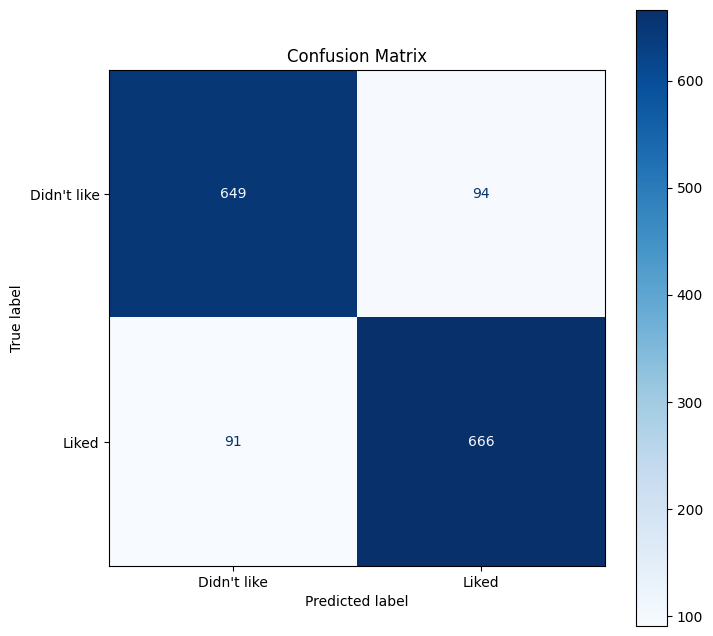

In [4]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Didn't like", "Liked"])

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [5]:
model.save_pretrained('../models/model')
tokenizer.save_pretrained('../models/tokenizer')

('../models/tokenizer/tokenizer_config.json',
 '../models/tokenizer/special_tokens_map.json',
 '../models/tokenizer/vocab.txt',
 '../models/tokenizer/added_tokens.json',
 '../models/tokenizer/tokenizer.json')

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

model_path = '../models/model'
tokenizer_path = '../models/tokenizer'

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

new_sample = "esse jogo é uma merda eu jamais jogaria novamente"

inputs = tokenizer(new_sample, return_tensors='pt', padding=True, truncation=True, max_length=512)

inputs = {key: value.to(device) for key, value in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()

label_map = {0: "Negative", 1: "Positive"}
print(f"Prediction: {label_map[prediction]}")


Prediction: Negative


In [7]:
new_sample = "eu amei esse jogo estou viciado"

inputs = tokenizer(new_sample, return_tensors='pt', padding=True, truncation=True, max_length=512)

inputs = {key: value.to(device) for key, value in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()

label_map = {0: "Negative", 1: "Positive"}
print(f"Prediction: {label_map[prediction]}")

Prediction: Positive
